In [5]:
try:
    import numpy as np
    import random   
    from scipy.optimize import minimize, linear_sum_assignment
    import itertools
    import matplotlib.pyplot as plt
except:
    !pip install matplotlib

In [6]:
import numpy as np
import random
from scipy.optimize import minimize, linear_sum_assignment
import itertools
import matplotlib.pyplot as plt

In [54]:
# set up outfield player dictionaries
# array format: [defender, central, winger, forward]

all_players = dict()

# re-write as preferences
all_players['jazzie'] = [('D',1), ('C',0), ('W',0), ('F',0)]
all_players['caroline'] = [('D',1), ('C',0), ('W',0), ('F',0)]
all_players['helen'] = [('D',1), ('C',0), ('W',3), ('F',0)]
all_players['christine'] = [('D',0), ('C',0), ('W',1), ('F',2)]
all_players['sian'] = [('D',1), ('C',0), ('W',1), ('F',0)]
all_players['vicky'] = [('D',0), ('C',1), ('W',2), ('F',2)]
all_players['keah'] = [('D',0), ('C',1.5), ('W',1), ('F',2)]
all_players['shafa'] = [('D',0), ('C',0), ('W',2), ('F',1)]
all_players['olivia'] = [('D',0), ('C',2), ('W',2), ('F',0)]
all_players['mychelle'] = [('D',4), ('C',1), ('W',0), ('F',1)]
all_players['jaz'] = [('D',0), ('C',3), ('W',1), ('F',0)]

#convert preferences to costs
player_costs = dict()

for player in all_players.keys():
    prefs = all_players[player]

    costs = []
    for x in prefs:
        cost = 1-(1/x[1]) if x[1]!=0 else 1.0
        costs.append((x[0], cost))
        
    player_costs[player] = costs
    
print(f'player_costs:\n {player_costs}')

player_costs:
 {'jazzie': [('D', 0.0), ('C', 1.0), ('W', 1.0), ('F', 1.0)], 'caroline': [('D', 0.0), ('C', 1.0), ('W', 1.0), ('F', 1.0)], 'helen': [('D', 0.0), ('C', 1.0), ('W', 0.6666666666666667), ('F', 1.0)], 'christine': [('D', 1.0), ('C', 1.0), ('W', 0.0), ('F', 0.5)], 'sian': [('D', 0.0), ('C', 1.0), ('W', 0.0), ('F', 1.0)], 'vicky': [('D', 1.0), ('C', 0.0), ('W', 0.5), ('F', 0.5)], 'keah': [('D', 1.0), ('C', 0.33333333333333337), ('W', 0.0), ('F', 0.5)], 'shafa': [('D', 1.0), ('C', 1.0), ('W', 0.5), ('F', 0.0)], 'olivia': [('D', 1.0), ('C', 0.5), ('W', 0.5), ('F', 1.0)], 'mychelle': [('D', 0.75), ('C', 0.0), ('W', 1.0), ('F', 0.0)], 'jaz': [('D', 1.0), ('C', 0.6666666666666667), ('W', 0.0), ('F', 1.0)]}


In [8]:
def get_this_week_player_costs(this_week, player_costs=player_costs):
    this_week_player_costs = dict()
    for player in this_week:
        this_week_player_costs[player] = player_costs[player]
    return this_week_player_costs

def dict_to_cost_matrix(player_costs, formation):
    cost_matrix = []
    for player in player_costs:
        cost_list = []
        for position in formation:
            for x in player_costs[player]:
                if x[0]==position:
                    cost_list.append(x[1])
        cost_matrix.append(cost_list)
    
    return np.array(cost_matrix)

def append_subs_to_cost_matrix(cost_matrix, subs_weights):
    n_subs = len(cost_matrix) - 6
    cost_matrix_with_subs = []
    for i in range(len(cost_matrix)):
        cost_list = list(cost_matrix[i])
        for j in range(n_subs):
            cost_list.append(subs_weights[i])
        cost_matrix_with_subs.append(cost_list)
    return np.array(cost_matrix_with_subs)

def alter_subs_weights(cost_matrix, subs_weights):
    n_subs = len(cost_matrix) - 6
    cost_matrix_with_subs = []
    for i in range(len(cost_matrix)):
        cost_list = list(cost_matrix[i])
        for j in range(n_subs):
            cost_list[-(j+1)] = subs_weights[i] 
        cost_matrix_with_subs.append(cost_list)
    return np.array(cost_matrix_with_subs)

def convert_lsa_output_to_formation(cm, row_ind, col_ind, this_week, formation_with_subs):
    formation_dict = {'D':[], 'C':[], 'W':[], 'F':[], 'S':[]}
    for i in range(len(col_ind)):
        position = formation_with_subs[col_ind[i]]
        player = this_week[i]
        formation_dict[position].append(player)
    formation_dict['cost'] = cm[row_ind, col_ind].sum()
    return formation_dict
    

In [56]:
# build cost matrix
this_week = ['mychelle', 'helen', 'keah', 'caroline', 'christine', 'vicky', 'sian', 'olivia', 'jaz']
# this_week = random.sample(all_players.keys(), 9)
random.shuffle(this_week)

print(this_week)
n_players_this_week = len(this_week)

formation = ['D', 'D', 'C', 'W', 'W', 'F']
formation_with_subs = formation.copy()
for i in range(n_players_this_week-6):
    formation_with_subs.append('S')

this_week_player_costs = get_this_week_player_costs(this_week)
cm_no_subs = dict_to_cost_matrix(this_week_player_costs, formation)

sub_weight = 1.0 # cost of subbed player getting subbed again
unpreferred_position_weight = 1.0 # cost of having a position filled by someone who doesn't have it as first preference

symmetric = True

if n_players_this_week == 9:
    if symmetric:
        n_repeats = 3
    else:
        n_repeats = 6
        sub_weight = 0.5
elif n_players_this_week == 8:
    if symmetric:
        n_repeats = 4
    else:
        n_repeats = 8
        sub_weight = 0.5
else:
    n_repeats = 7

#n_repeats = 6 # how many periods to split game into

['helen', 'mychelle', 'sian', 'olivia', 'christine', 'keah', 'jaz', 'caroline', 'vicky']


In [57]:
initial_subs_weights = np.zeros(n_players_this_week)
cm = append_subs_to_cost_matrix(cm_no_subs, initial_subs_weights)
cm_init = cm

subs_weights = initial_subs_weights.copy()

print(f'n_players_this_week: {n_players_this_week}')
print(f'n_repeats: {n_repeats}')
print(f'cm size: {cm.shape}')
print(f'Initial cost_matrix [cm]:\n {cm_init}')
print(f'Initial subs_weights:\n {subs_weights}\n')

for i in range(n_repeats):
    row_ind, col_ind = linear_sum_assignment(cm)
    # print(convert_lsa_output_to_formation(cm, row_ind, col_ind, this_week, formation_with_subs))
    
    for i in range(len(row_ind)):
        if formation_with_subs[col_ind[i]]=='S':
            subs_weights[i] += sub_weight
        
    cm = alter_subs_weights(cm, subs_weights)
    
    print(f'cost_matrix [cm]:\n {cm}')
    print(f'subs_weights:\n {subs_weights}')
    print(f'cm_diff:\n {cm-cm_init}')
    
    #TODO: also alter position weights to maintain position?

n_players_this_week: 9
n_repeats: 3
cm size: (9, 9)
Initial cost_matrix [cm]:
 [[0.         0.         1.         0.66666667 0.66666667 1.
  0.         0.         0.        ]
 [0.75       0.75       0.         1.         1.         0.
  0.         0.         0.        ]
 [0.         0.         1.         0.         0.         1.
  0.         0.         0.        ]
 [1.         1.         0.5        0.5        0.5        1.
  0.         0.         0.        ]
 [1.         1.         1.         0.         0.         0.5
  0.         0.         0.        ]
 [1.         1.         0.33333333 0.         0.         0.5
  0.         0.         0.        ]
 [1.         1.         0.66666667 0.         0.         1.
  0.         0.         0.        ]
 [0.         0.         1.         1.         1.         1.
  0.         0.         0.        ]
 [1.         1.         0.         0.5        0.5        0.5
  0.         0.         0.        ]]
Initial subs_weights:
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]



In [33]:
def objective_function(x, cm_no_subs, n_repeats):
    
    vals = []
    
    cm = append_subs_to_cost_matrix(cm_no_subs, x)
    subs_weights = x.copy()
    
    for i in range(n_repeats):
        row_ind, col_ind = linear_sum_assignment(cm)
        #print(f'rows {row_ind} cols {col_ind}')
        formation_dict = convert_lsa_output_to_formation(cm, row_ind, col_ind, this_week, formation_with_subs)
        #print(f'formation dict: {formation_dict}')

        for i in range(len(row_ind)):
            if formation_with_subs[col_ind[i]]=='S':
                subs_weights[i] += 1.0
            elif i<len(row_ind)-1 and formation_with_subs[col_ind[i]]==formation_with_subs[col_ind[i+1]]:
                if cm[row_ind[i], col_ind[i]]*cm[row_ind[i+1], col_ind[i+1]] != 0:
                    formation_dict['cost'] += 1.0; # try and penalise case where no preferred position
        
        vals.append(formation_dict['cost'])
        cm = alter_subs_weights(cm, subs_weights)
    
    val = np.var(vals)
    #print(x, val)
    
    return val

this_week_player_costs = get_this_week_player_costs(this_week)
cm_no_subs = dict_to_cost_matrix(this_week_player_costs, formation)
#cm = append_subs_to_cost_matrix(cm_no_subs, np.zeros(n_players_this_week))

# n_repeats = 0
# if n_players_this_week == 7:
#     n_repeats = 7
# elif n_players_this_week == 8:
#     n_repeats = 4
# elif n_players_this_week == 9:
#     n_repeats = 3

bound = (0, 1)
bounds = []
for i in range(n_players_this_week):
    bounds.append(bound)
    
res = minimize(objective_function, x0=np.zeros(n_players_this_week), args=(cm_no_subs, n_repeats), bounds=bounds, method='SLSQP', options={'eps':0.1})
print(res)



     fun: 0.061170777282773724
     jac: array([0.25472389, 0.25472389, 0.25472389, 0.25472389, 0.06969395,
       0.25472389, 0.25472389, 0.25472389, 0.25472389])
 message: 'Optimization terminated successfully'
    nfev: 42
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([2.89722595e-17, 1.45591081e-17, 1.46196452e-17, 9.24381680e-25,
       4.53742514e-01, 3.05394428e-17, 9.06626724e-17, 1.53706220e-24,
       3.05394432e-17])


todo:
* set up cost matrix
* follow through to end of match
* if later combinations are forbidden, go back and adjust sub weights?
* could turn into a meta-optimisation problem, where you are trying to optimise the inital subs weights per player to minimise total cost to team
* integrate small weight reduction to incentivise not changing position
* dynamic cost matrix - can i prevent failure cases where algorithm wastes all best combinations early on?

In [14]:
initial_subs_weights = res.x
cm = append_subs_to_cost_matrix(cm_no_subs, initial_subs_weights)
    
subs_weights = initial_subs_weights.copy()
formations_for_plotting = [] 

for i in range(n_repeats):
    row_ind, col_ind = linear_sum_assignment(cm)
    out = convert_lsa_output_to_formation(cm, row_ind, col_ind, this_week, formation_with_subs)
    
    print(out)
    
    this_formation = ['etsuko']
    for position in ['D', 'C', 'W', 'F', 'S']:
        for player in out[position]:
            this_formation.append(player)
    
    formations_for_plotting.append(this_formation)
    
    for i in range(len(row_ind)):
        if formation_with_subs[col_ind[i]]=='S':
            subs_weights[i] += sub_weight
    cm = alter_subs_weights(cm, subs_weights)

{'D': ['helen', 'caroline'], 'C': ['vicky'], 'W': ['christine', 'keah'], 'F': ['mychelle'], 'S': ['jaz', 'olivia', 'sian'], 'cost': 0.45374251440262015}
{'D': ['sian', 'caroline'], 'C': ['olivia'], 'W': ['jaz', 'keah'], 'F': ['mychelle'], 'S': ['vicky', 'helen', 'christine'], 'cost': 0.5}
{'D': ['helen', 'sian'], 'C': ['vicky'], 'W': ['jaz', 'christine'], 'F': ['olivia'], 'S': ['mychelle', 'keah', 'caroline'], 'cost': 1.0}


In [15]:
def plot_formation(formation, t_start, t_stop):
    # format for formation should be: GK, LB, RB, C, LW, RW, CF, S, S, S
    plt.figure(figsize=[6,6])
    make_pitch()
    
    positions_x = [2.5, 1.5, 3.5, 2.5, 0.5, 4.5, 2.5, 6.5, 6.5, 6.5]
    positions_y = [4, 2.8, 2.8, 1.6, 1, 1, 0, 3, 2, 1]
    
    if len(formation)==10:
        positions_x.append(6.5)
        positions_y.append(0)
        
    formation.append('pete')
    
    for i in range(len(formation)):
        plt.annotate(formation[i], (positions_x[i], positions_y[i]+0.25), color='white', fontsize=14, ha='center')
    
    plt.plot(positions_x, positions_y, 'o', ms=10, markerfacecolor='red', markeredgecolor='white')
    
    plt.annotate(f'{t_start} - {t_stop} mins', (3.5, 5), color='white', fontsize=14, ha='center' )
    
def make_pitch():
    #plt.figure(figsize=[6,6])
    plt.xlim([-1, 8])
    plt.ylim([-1, 5.5])
    plt.hlines([4.5, -0.5], -0.5, 5.5, color='white' )
    plt.hlines(3.5, 1.5, 3.5, color='white')
    plt.vlines([-0.5, 5.5], -0.5, 4.5, color='white')
    plt.vlines([1.5, 3.5], 3.5, 4.5, color='white')

    plt.plot([2.5], [-0.5], 'o', ms=5, color='w')
    
    ax = plt.gca()
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax.set_facecolor('green')
    
    return ax

def plot_formations(formations, t_starts, t_stops):
    n_repeats = len(formations)
    
    fig, axs = plt.subplots(1, n_repeats, figsize=[6*n_repeats,6])
    
    for i in range(n_repeats):
        axs[i] = make_pitch()
        
        formation = formation[i]
        t_start = t_starts[i]
        t_stop = t_stops[i]
        
        plot_formation(formation, t_start, t_stop)
    


In [27]:
# plot_formations(formations_for_plotting, [0, 8, 16], [8, 16, 25])

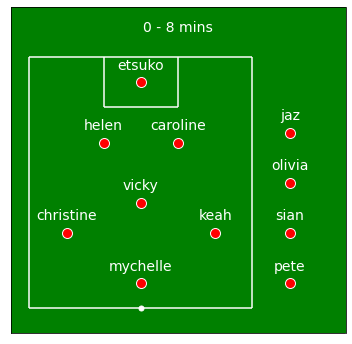

In [17]:
plot_formation(formations_for_plotting[0], 0, 8)

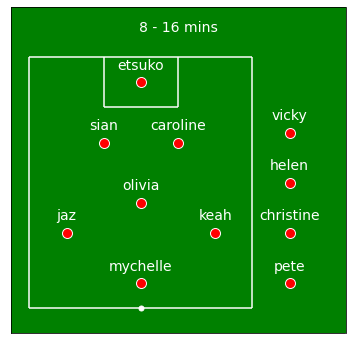

In [18]:
plot_formation(formations_for_plotting[1], 8, 16)

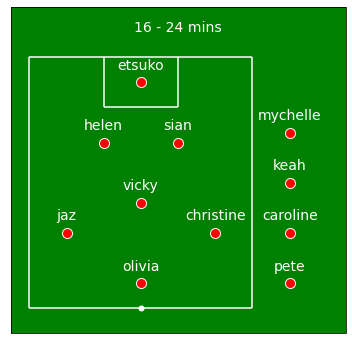

In [19]:
plot_formation(formations_for_plotting[2], 16, 24)

In [28]:
# plot_formations(formations_for_plotting)

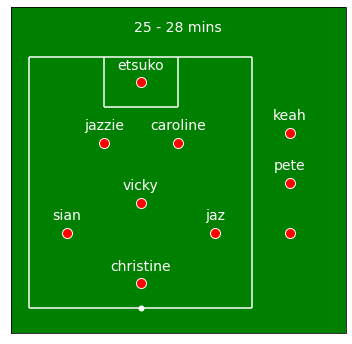

In [21]:
plot_formation(['etsuko','jazzie', 'caroline','vicky','sian', 'jaz','christine','keah'],  25, 28)

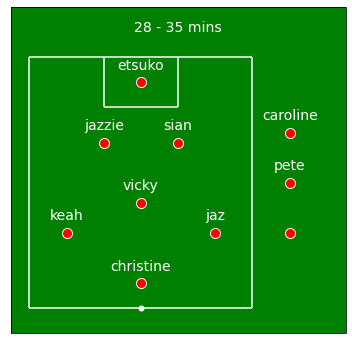

In [22]:
plot_formation(['etsuko','jazzie', 'sian','vicky','keah', 'jaz','christine','caroline'],  28, 35)

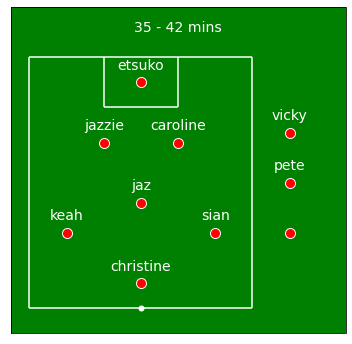

In [23]:
plot_formation(['etsuko','jazzie', 'caroline','jaz','keah', 'sian','christine','vicky'],  35, 42)

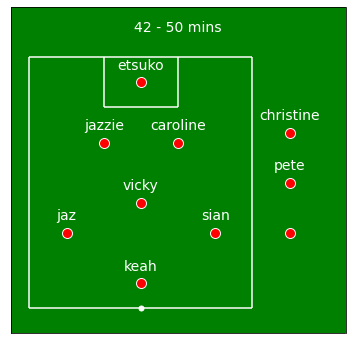

In [24]:
plot_formation(['etsuko','jazzie', 'caroline','vicky','jaz', 'sian','keah','christine'],  42, 50)